### Import Libraries

In [299]:
import numpy as np
from numpy.linalg import inv
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import pandas as pd

### Define Functions

In [5]:
def sample_jester_data(file_name, context_dim = 32, num_actions = 8, num_contexts = 19181,
                       shuffle_rows=True, shuffle_cols=False):
    """Samples bandit game from (user, joke) dense subset of Jester dataset.
        Args:
            file_name: Route of file containing the modified Jester dataset.
            context_dim: Context dimension (i.e. vector with some ratings from a user).
            num_actions: Number of actions (number of joke ratings to predict).
            num_contexts: Number of contexts to sample.
            shuffle_rows: If True, rows from original dataset are shuffled.
            shuffle_cols: Whether or not context/action jokes are randomly shuffled.
        Returns:
            dataset: Sampled matrix with rows: (context, rating_1, ..., rating_k).
            opt_vals: Vector of deterministic optimal (reward, action) for each context.
    """
    np.random.seed(0)
    with tf.gfile.Open(file_name, 'rb') as f:
        dataset = np.load(f)
    if shuffle_cols:
        dataset = dataset[:, np.random.permutation(dataset.shape[1])]
    if shuffle_rows:
        np.random.shuffle(dataset)
    dataset = dataset[:num_contexts, :]
    assert context_dim + num_actions == dataset.shape[1], 'Wrong data dimensions.'
    opt_actions = np.argmax(dataset[:, context_dim:], axis=1)
    opt_rewards = np.array([dataset[i, context_dim + a] for i, a in enumerate(opt_actions)])
    return dataset, opt_rewards, opt_actions

In [287]:
def rargmax(vector, epsilon):
    """ Argmax that chooses randomly among eligible maximum indices
        while following an epsilon greedy policy schedule."""
    ep_greedy = np.random.rand() # pick random number
    if ep_greedy < epsilon: # if epsilon greedy wins
        pick = random.choice(range(len(vector)))
    else: 
        m = np.amax(vector)
        indices = np.nonzero(vector == m)[0]
        pick = random.choice(indices)
    return pick

### Read in Data

In [249]:
# read in and store data 
dataset, opt_rewards, opt_actions = sample_jester_data('jester_data_40jokes_19181users.npy')

### Train Algorithm 
Using first 18,000 users

In [362]:
# initialize all of the things
alpha = 1.5 # UCB hyperparameter 
epsilon_greedy = list(np.repeat(0.1, 1000)) + list(np.repeat(0.99, n)) # schedule 

n = 18000 # number of users for training/tuning
k = 32 # context
a = 8 # arms

th = np.random.random((a, k)) - 0.5 # theta, truth

choices = np.zeros(n)
rewards = np.zeros(n)

b = np.zeros_like(th) # multiplication of context & rewards
A = np.zeros((a, k, k)) # for each action, identity matrix that's k x k

for a in range (0, a): # initialize all arms as identity matrix
    A[a] = np.identity(k)

# run contextual bandit    
earned_rewards = []
for user in range(n):
    
    context = dataset[user][:k] # X
    true_rewards = dataset[user][k:] # y
    
    p_ta = [] # keep track of predicted rewards
    for action in range(a+1):
        A_inverse = inv(A[action])
        th[action] = np.matmul(A_inverse, b[action])
        
        mu = np.matmul(th[action].reshape(1,k), context)[0]
        cb = alpha * np.sqrt(np.matmul(np.matmul(context.reshape(1,k), A_inverse), context))[0]
        p_ta.append(mu + cb)
    
    pick = rargmax(p_ta, user, epsilon_greedy[user])
    A[pick] = A[pick] + np.matmul(context, context.reshape(k,1))
    b[pick] = b[pick] + true_rewards[pick] * context
    earned_rewards.append(true_rewards[pick])

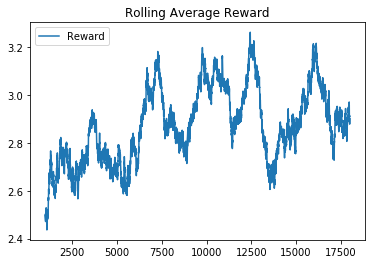

In [363]:
results = pd.DataFrame(earned_rewards)
results.columns = ['Reward']
results.rolling(1000).mean().plot()
plt.title("Rolling Average Reward");

### Test Algorithm

In [365]:
regret = []
for user in range(n, len(dataset)):
    context = dataset[user][:k] # X
    true_rewards = dataset[user][k:] # y
    
    p_ta = [] # keep track of predicted rewards
    for action in range(a+1):
        A_inverse = inv(A[action])
        th[action] = np.matmul(A_inverse, b[action])
        
        mu = np.matmul(th[action].reshape(1,k), context)[0]
        cb = alpha * np.sqrt(np.matmul(np.matmul(context.reshape(1,k), A_inverse), context))[0]
        p_ta.append(mu + cb)
    
    pick = rargmax(p_ta, user, 1)
    user_regret = np.max(true_rewards) - true_rewards[pick]
    regret.append(user_regret)

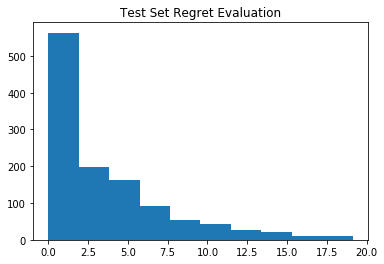

In [371]:
plt.hist(regret)
plt.title("Test Set Regret Evaluation");